# Introdução a Análise de Grafos

Os exemplos usam um dataset de reclamações registradas por cidadãos. O dataset foi derivado de dados do [Portal de Dados Abertos da Prefeitura de Curitiba](https://www.curitiba.pr.gov.br/DADOSABERTOS/).

Usaremos a biblioteca [NetworkX](https://networkx.github.io) para construir e analisar os grafos. O NetworkX oferece vários algoritmos de análise, plotagem e exportação de grafos.

In [1]:
#importação de bibliotecas
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Construindo um grafo

O código abaixo inicializa um grafo direcionado usando `nx.DiGraph()`. Para adicionar nós e ligações, usamos os métodos `add_nodes` e `add_edges`.

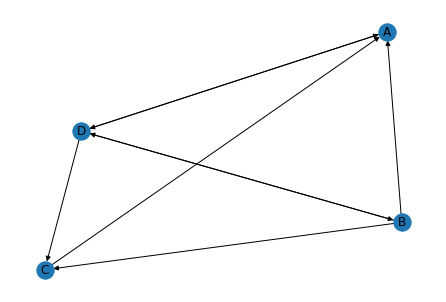

In [11]:
# Inicializa um grafo direcionado
G = nx.DiGraph()

# Define o label de cada nó
labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

G.add_nodes_from(labels)

# Adiciona links a partir de uma lista
G.add_edges_from([(1,2),(1,0),(2,0),(3,0),(3,1),(3,2),(0,3)])

# Adiciona um link
G.add_edge(1,3)

# Desenha o grafo
nx.draw(G, labels = labels)

## Construindo um grafo a partir de um DataFrame

É possível construir um grafo a partir de colunas de um DataFrame. As colunas devem indicar os nós de origem e destino das ligações. 

Usando o DataSet de reclamações, podemos construir um grafo ligando os bairros de origem dos cidadãos (BAIRRO_CIDADAO) e os respectivos bairros alvo das reclamações. 

In [3]:
# lê o arquivo CSV
df = pd.read_csv('../data/2017-02-01_156_-_Base_de_Dados_sample.csv', sep=';', encoding='latin-1')

Visualizando algumas linhas de dados:

In [4]:
df.head(3)

,SOLICITACAO,TIPO,ORGAO,DATA,HORARIO,ASSUNTO,SUBDIVISAO,DESCRICAO,LOGRADOURO_ASS,BAIRRO_ASS,REGIONAL_ASS,MEIO_RESPOSTA,OBSERVACAO,SEXO,BAIRRO_CIDADAO,REGIONAL_CIDADAO,DATA_NASC,TIPO_CIDADAO,ORGAO_RESP,RESPOSTA_FINAL
0,6669771,SOLICITAÇÃO,INSTITUTO DAS CIDADES INTELIGENTES,09/11/2016,21:02:44,ABORDAGEM SOCIAL DE RUA - ADULTO,PESSOAS/FAMÍLIAS EM DESABRIGO NA RUA,ABORDAGEM SOCIAL DE RUA - ADULTO - PESSOAS/FAM...,"ANDRE DE BARROS, 0",CENTRO,Unidade Regional Matriz,NENHUM,NÃO SOUBE INFORMAR NUMERAÇÃO PREDIAL,M,NaN,NaN,NaN,CIDADÃO,FUNDAÇÃO DE AÇÃO SOCIAL,Abordagem realizada. Pessoa foi orientada quan...
1,6718351,SOLICITAÇÃO,INSTITUTO DAS CIDADES INTELIGENTES,27/12/2016,00:40:04,ABORDAGEM SOCIAL DE RUA - ADULTO,PERDIDA/DESORIENTADA,ABORDAGEM SOCIAL DE RUA - ADULTO - PERDIDA/DES...,"NILO CAIRO, 0",CENTRO,Unidade Regional Matriz,NENHUM,"NÃO SOUBE INFORMAR NUMERAÇÃO PREDIAL, RELATA E...",M,NaN,NaN,NaN,CIDADÃO,FUNDAÇÃO DE AÇÃO SOCIAL,"EM ABORDAGEM REALIZADA, NÃO FOI ENCONTRADA A P..."
2,6702371,SOLICITAÇÃO,INSTITUTO DAS CIDADES INTELIGENTES,07/12/2016,14:09:42,ABORDAGEM SOCIAL DE RUA - CRIANÇA,ALCOOLIZADAS/DROGADAS,ABORDAGEM SOCIAL DE RUA - CRIANÇA - ALCOOLIZAD...,"VISCONDE DE NACAR, 1210",CENTRO,Unidade Regional Matriz,NENHUM,NaN,F,NaN,NaN,NaN,CIDADÃO,FUNDAÇÃO DE AÇÃO SOCIAL,"- EM ABORDAGEM REALIZADA, NÃO FOI ENCONTRADA A..."


Isolando as colunas de interesse e calculando o peso das ligações (número de vezes que cada par de bairros aparece).

In [5]:
# Elimando valores em branco
df_g = df[['BAIRRO_ASS', 'BAIRRO_CIDADAO']].dropna(how='any')

# Retirando pares de nós iguais
df_g = df_g[df_g['BAIRRO_ASS'] != df_g['BAIRRO_CIDADAO']]

# Contando quantidade de ligações iguais para representar o peso da ligação
df_g = df_g.groupby(['BAIRRO_ASS', 'BAIRRO_CIDADAO']).size().reset_index(name = 'weight')

# Filtrando apenas ligações com peso maior que 1
df_g = df_g[df_g['weight'] > 1]

df_g

,BAIRRO_ASS,BAIRRO_CIDADAO,weight
4,ABRANCHES,TABOAO,2
9,AGUA VERDE,BACACHERI,2
10,AGUA VERDE,BATEL,3
11,AGUA VERDE,BOA VISTA,2
16,AGUA VERDE,CAPAO DA IMBUIA,4
...,...,...,...
941,XAXIM,ALTO BOQUEIRAO,6
943,XAXIM,BOQUEIRAO,11
947,XAXIM,FANNY,2
950,XAXIM,PINHEIRINHO,5


Inicializando o grafo a partir do DataFrame processado.

In [6]:
G = nx.convert_matrix.from_pandas_edgelist(df_g, 'BAIRRO_ASS', 'BAIRRO_CIDADAO', ['weight'])

type(G)

networkx.classes.graph.Graph

## Análise do grafo

O NetworkX permite o cálculo de diversas métricas sobre os grafos. Uma categoria importante é a das métricas de centralidade, que estimam a importância dos nós na rede. Uma dessas métricas é a **centralidade de autovetor**. No código abaixo calculamos a centralidade e exibimos um gráfico com os bairros mais importantes de acordo com a métrica.

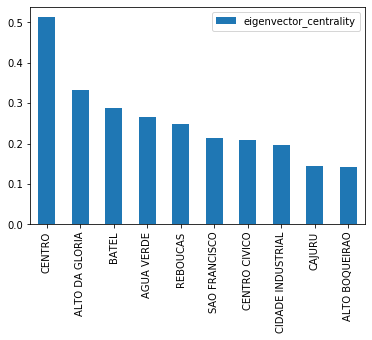

In [7]:
# Calculando os valores de centralidade
eigenvector_centrality=nx.eigenvector_centrality_numpy(G, weight='weight')

# Atribuindo os valores aos nós do grafo
nx.set_node_attributes(G, eigenvector_centrality, 'eigenvector_centr')

# Exibindo os valores em um gráfico de barras
df_importancia = pd.DataFrame([eigenvector_centrality], index=['eigenvector_centrality']).T
df_importancia.sort_values('eigenvector_centrality', ascending=False).head(10).plot.bar()

Para plotar o grafo, usamos o método `draw()`. Para definir a posição dos nós, usamos o spring layout.

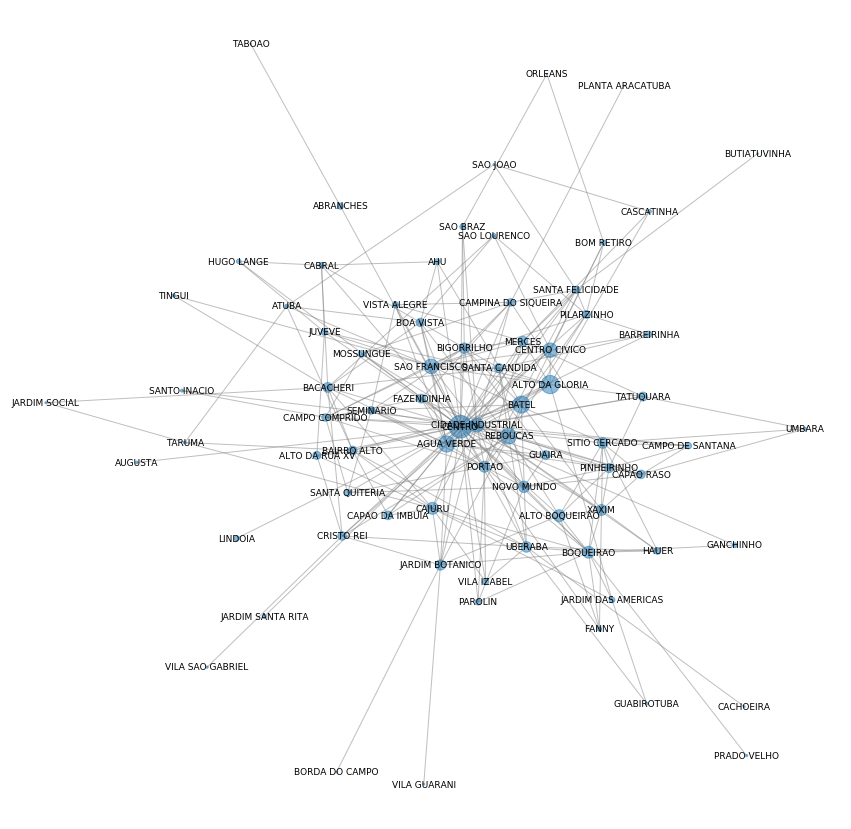

In [8]:
plt.figure(figsize=(15, 15))

node_sizes = [v * 1000 for v in eigenvector_centrality.values()]

# Define as posições para exibição dos nós
pos = nx.spring_layout(G)

# Desenha os rótulos (bairros)
nx.draw_networkx_labels(G, pos, font_size = 9)

# Desenha o restante do grafo
nx.draw(G, pos, node_size=node_sizes, alpha = 0.5, edge_color='grey')

Obtendo os atributos de um nó:

In [9]:
G.nodes['CENTRO']

{'eigenvector_centr': 0.5123750828976518}

Obtendo as ligações de um nó:

In [10]:
G.edges('HAUER')

EdgeDataView([('HAUER', 'BOQUEIRAO'), ('HAUER', 'CIDADE INDUSTRIAL'), ('HAUER', 'SITIO CERCADO'), ('HAUER', 'UBERABA'), ('HAUER', 'XAXIM')])